# **Q1**


In [ ]:
CREATE SCHEMA IF NOT EXISTS news;

CREATE TABLE IF NOT EXISTS news.google_news(
	id SERIAL PRIMARY KEY,
	title TEXT NOT NULL,
	link TEXT NOT NULL,
	pubdate TIMESTAMP WITH TIME ZONE NOT NULL,
	description TEXT,
	source TEXT NOT NULL,
	UNIQUE (title, link)
);

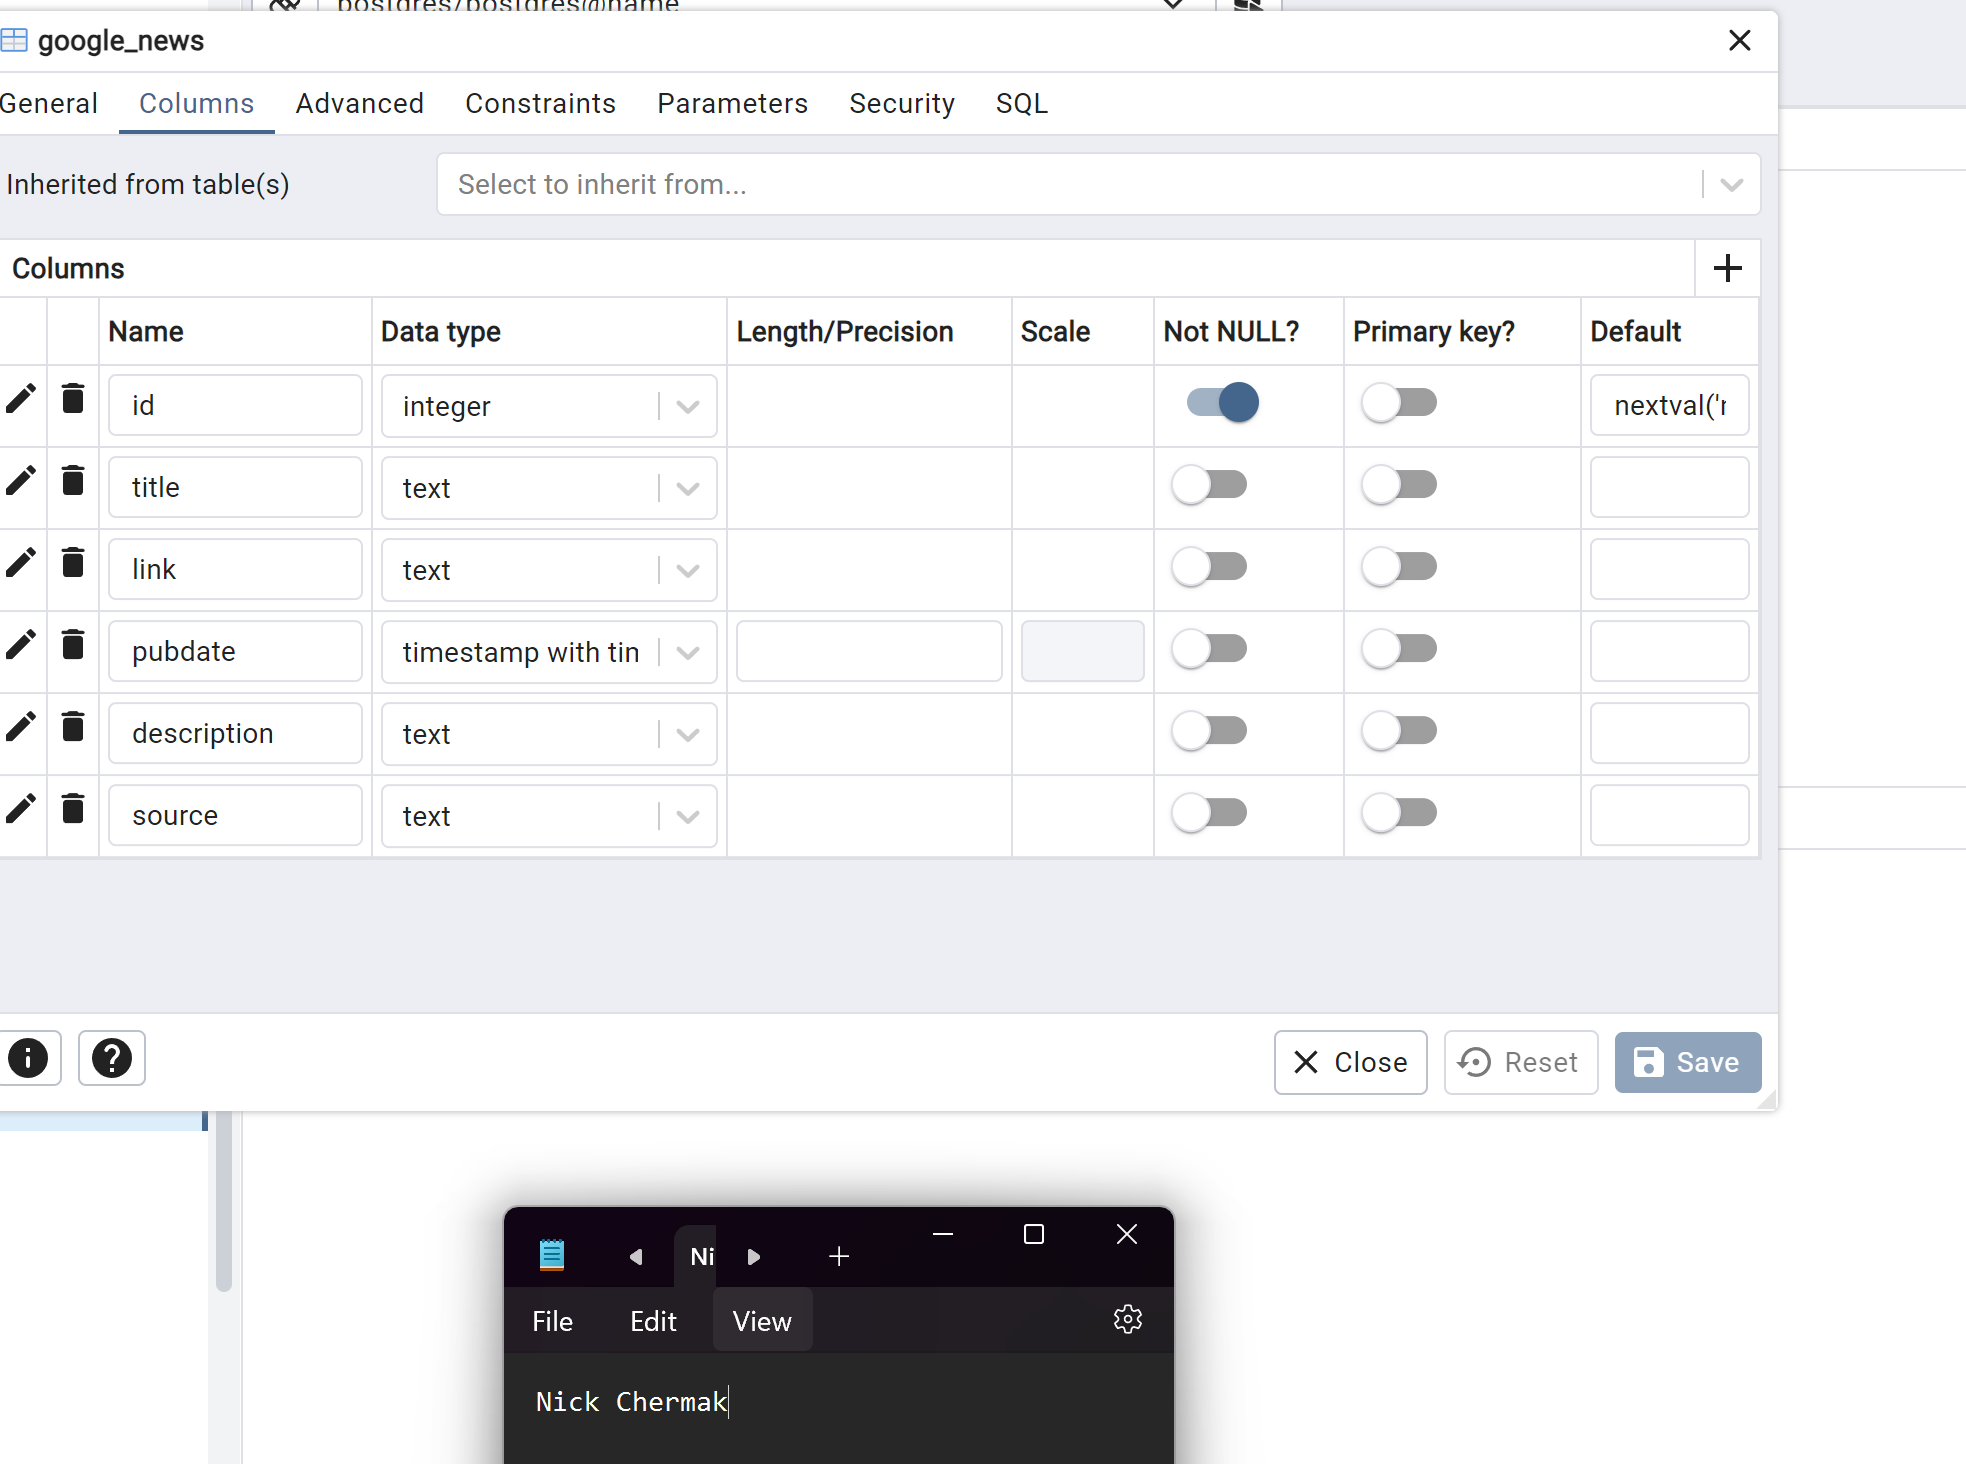

# **Q2**


In [14]:
import findspark
findspark.init()
findspark.find()

import requests
import feedparser
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from datetime import datetime
import pytz
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

# Initialize Spark
appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default
sc = SparkContext.getOrCreate(conf=conf)
# You need to create SQL Context to conduct some database operations like what we will
sqlContext = SQLContext(sc)
# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

# Get Data
url = "https://news.google.com/rss/search?q=technology&hl=en-US&gl=US&ceid=US:en"
feed = feedparser.parse(url)

def parse_pubDate(pubDate):
    try:
        #parse date
        dt = datetime.strptime(pubDate, "%a, %d %b %Y %H:%M:%S %Z")
        dt = dt.replace(tzinfo=pytz.utc) #set to GMT
        return dt
    except Exception as e:
        print(f"Error parsing pubDate '{pubDate}': {e}")
        return None
    
data = []
for entry in feed.entries:
    title = entry.title
    link = entry.link
    pubdate = parse_pubDate(entry.published)
    description = entry.summary if 'summary' in entry else None
    source = entry.source.title if 'source' in entry else 'Unknown'
    
    data.append((title, link, pubdate, description, source))

schema = StructType([
    StructField("title", StringType(), False),
    StructField("link", StringType(), False),
    StructField("pubdate", TimestampType(), False),
    StructField("description", StringType(), True),
    StructField("source", StringType(), False)
])

rdd = spark.sparkContext.parallelize(data)
spark_df = spark.createDataFrame(rdd, schema)

jdbc_url = "jdbc:postgresql://localhost:5432/postgres"
properties = {
    "user": "postgres",
    "password": "Nicknac1117+",
    "driver": "org.postgresql.Driver"
}

# Write data to PostgreSQL
#spark_df.write.jdbc(url=jdbc_url, table="news.google_news", mode="append", properties=properties)
try:
    spark_df.write.jdbc(url=jdbc_url, table="news.google_news", mode="append", properties=properties)
    print("Data written successfully.")
except Exception as e:
    print(f"Error writing to PostgreSQL: {e}")
    import traceback
    traceback.print_exc()



Data written successfully.


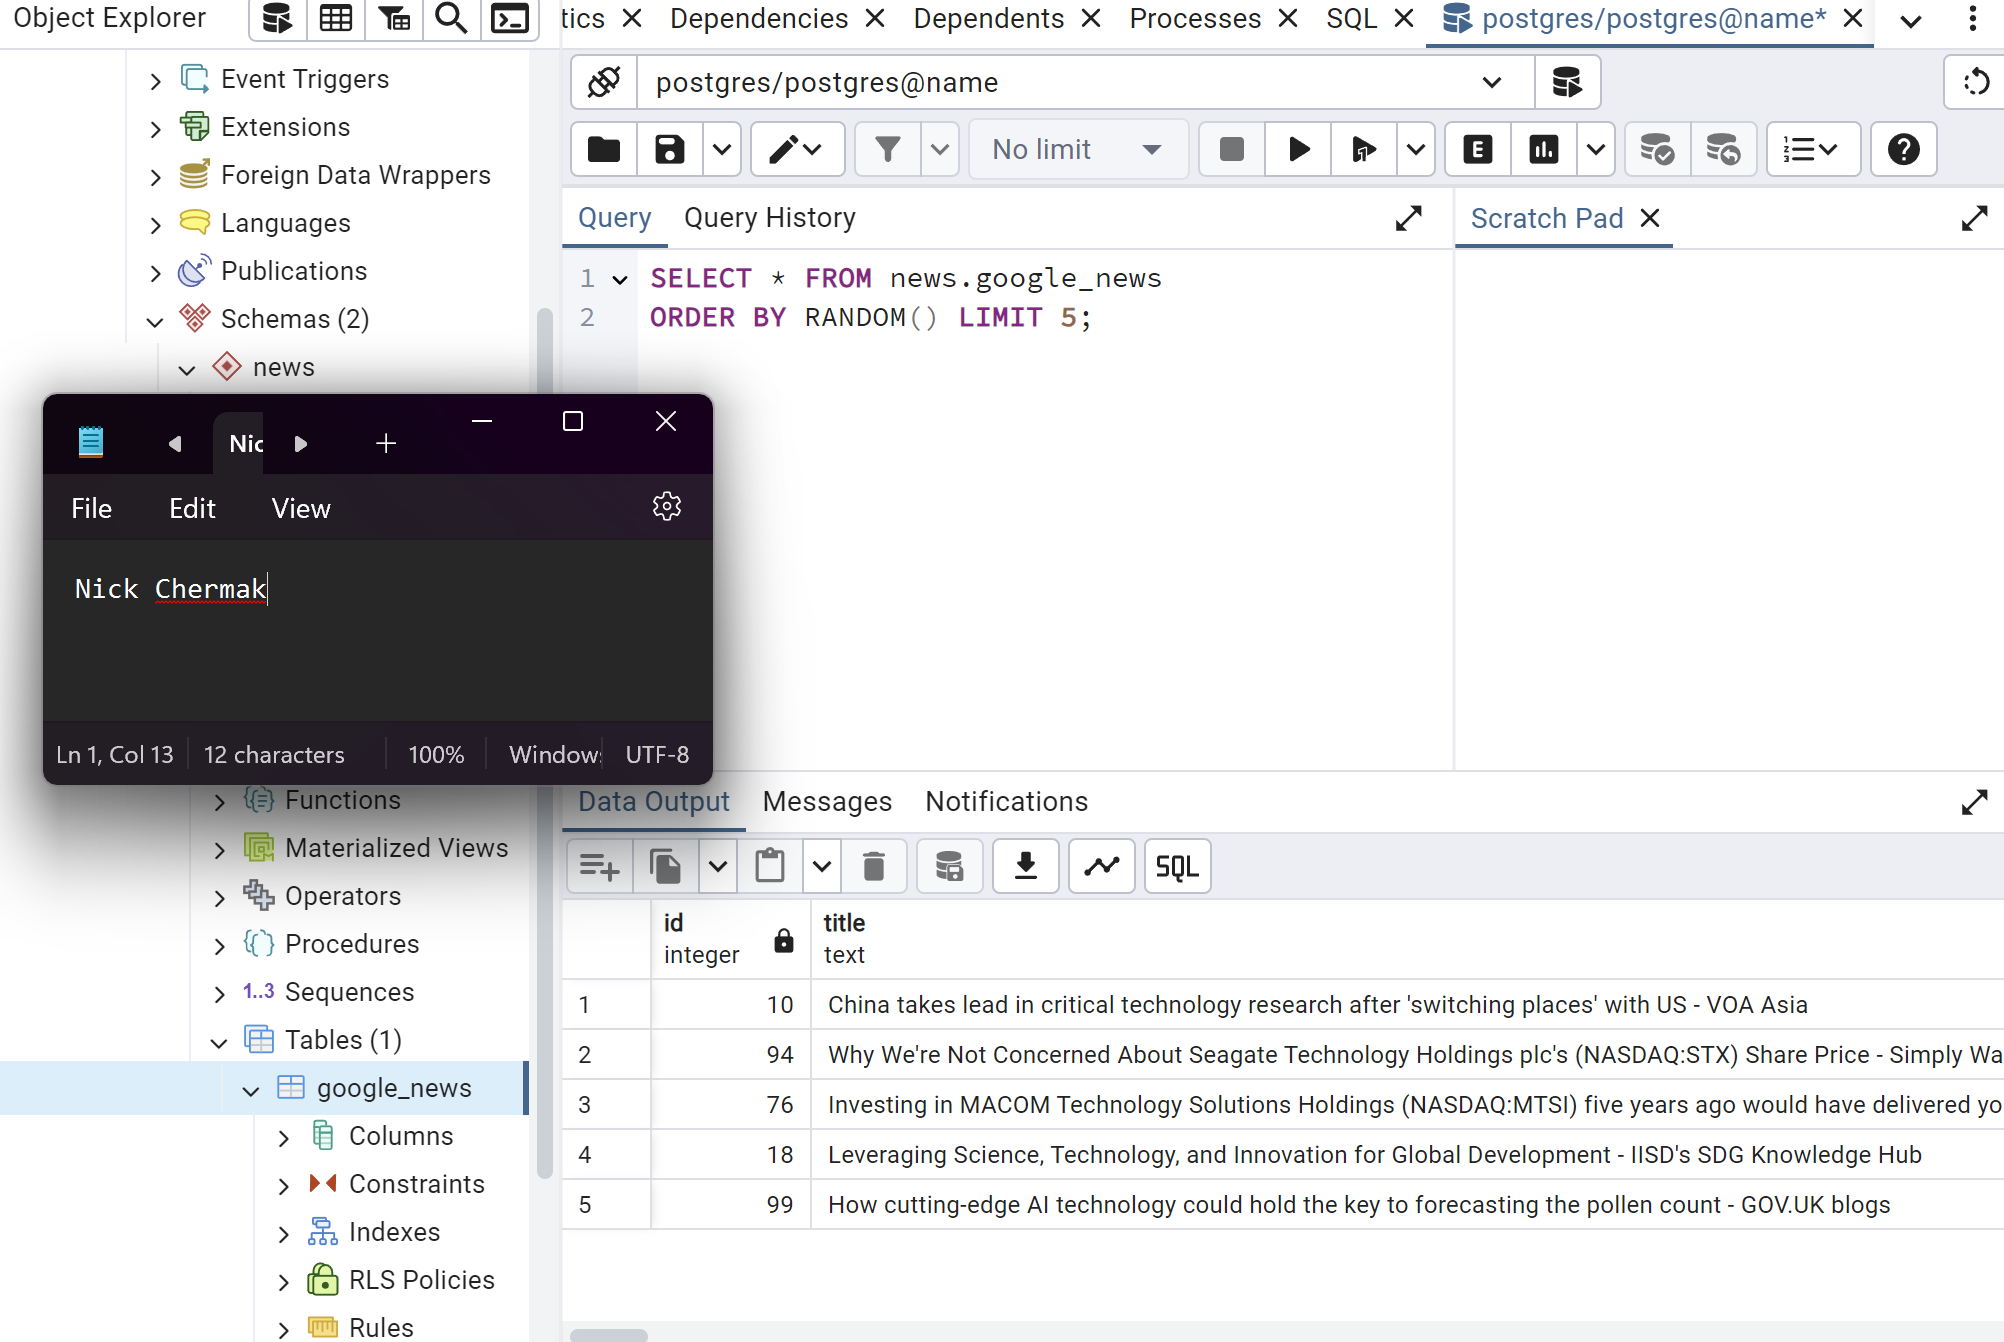

# **Q3**

In [12]:
from datetime import timedelta

# Function to find all the news that were published in the last 24 hours.
def get_recent_news(spark, jdbc_url, properties):
    last_24_hours = datetime.now(pytz.utc) - timedelta(days=1)
    query = f"""
    SELECT * 
    FROM news.google_news
    WHERE pubdate >= '{last_24_hours.isoformat()}'
    """
    
    try:
        recent_news_df = spark.read.jdbc(url=jdbc_url, table=f"({query}) as recent_news", properties=properties)
        return recent_news_df
    except Exception as e:
        print(f"Error fetching recent news: {e}")
        import traceback
        traceback.print_exc()
        return None
    
# Fetch and display recent news
recent_news_df = get_recent_news(spark, jdbc_url, properties)
if recent_news_df:
    recent_news_df.show(truncate=False)

+----+---------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

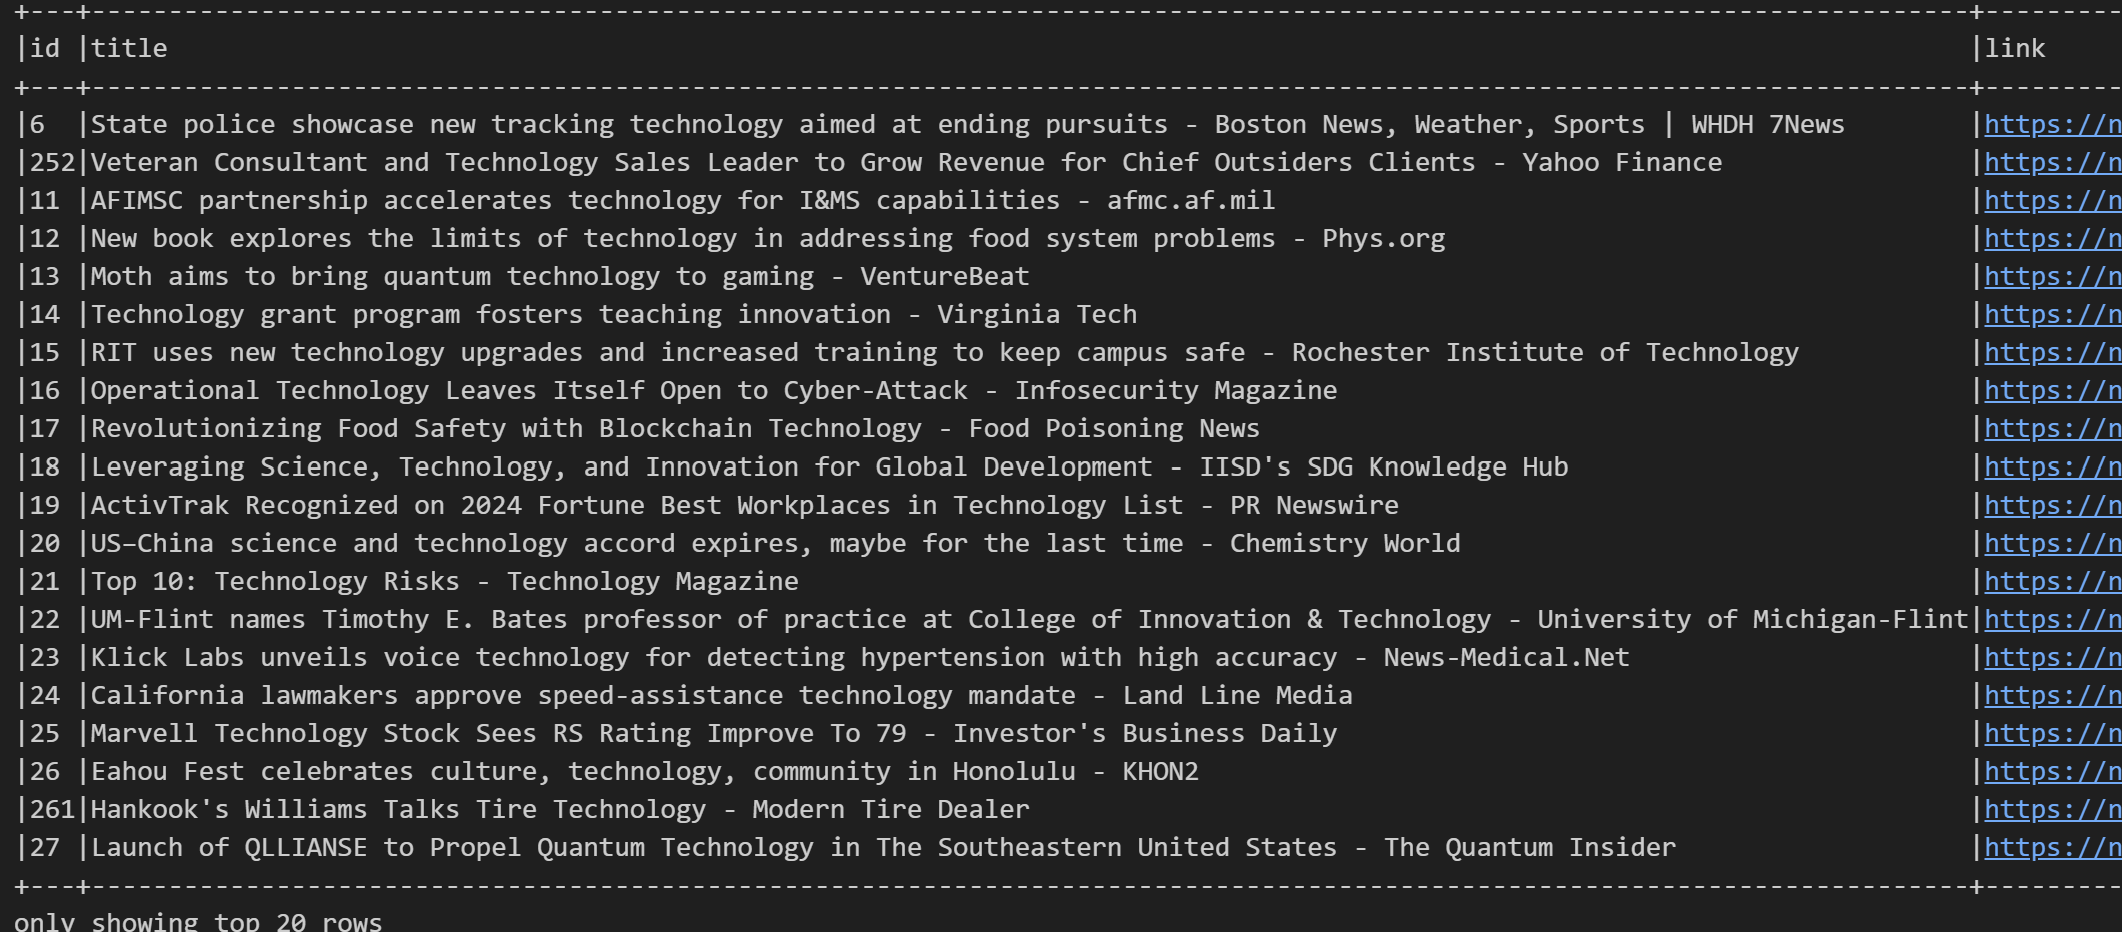 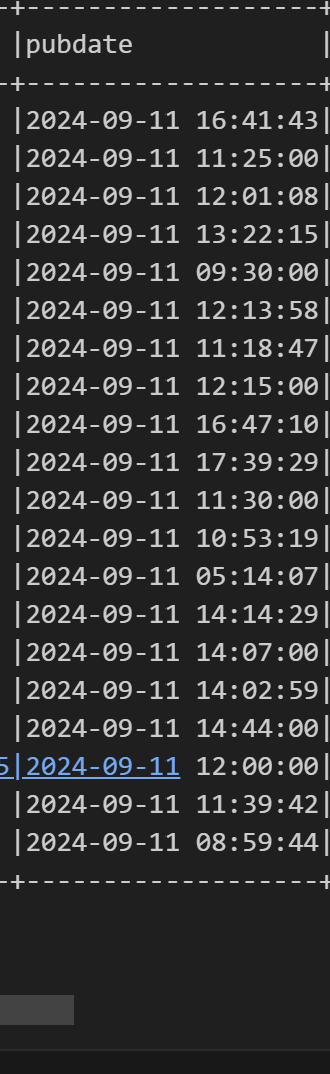

# **Q4**

In [ ]:
ALTER TABLE news.google_news ADD COLUMN category VARCHAR(50) DEFAULT 'technology';

In [13]:
business_url = "https://news.google.com/rss/search?q=business&hl=en-US&gl=US&ceid=US:en"
sports_url = "https://news.google.com/rss/search?q=sports&hl=en-US&gl=US&ceid=US:en"

#need to add technology so can add to business and sports
tech_data = [(title, link, pubdate, description, source, 'technology') for (title, link, pubdate, description, source) in data]

#business data
business_feed = feedparser.parse(business_url)
business_data = []
for entry in business_feed.entries:
    title = entry.title
    link = entry.link
    pubdate = parse_pubDate(entry.published)
    description = entry.summary if 'summary' in entry else None
    source = entry.source.title if 'source' in entry else 'Unknown'
    business_data.append((title, link, pubdate, description, source, 'business'))

#sports data
sports_feed = feedparser.parse(sports_url)
sports_data = []
for entry in sports_feed.entries:
    title = entry.title
    link = entry.link
    pubdate = parse_pubDate(entry.published)
    description = entry.summary if 'summary' in entry else None
    source = entry.source.title if 'source' in entry else 'Unknown'
    sports_data.append((title, link, pubdate, description, source, 'sports'))

all_data = tech_data + business_data + sports_data

# Update from question 2:
updated_schema = StructType([
    StructField("title", StringType(), False),
    StructField("link", StringType(), False),
    StructField("pubdate", TimestampType(), False),
    StructField("description", StringType(), True),
    StructField("source", StringType(), False),
    StructField("category", StringType(), False)
])

rdd_new = spark.sparkContext.parallelize(all_data)
new_spark_df = spark.createDataFrame(rdd_new, updated_schema)

try:
    new_spark_df.write.jdbc(url=jdbc_url, table="news.google_news", mode="append", properties=properties)
    print("Business and Sports data written successfully.")
except Exception as e:
    print(f"Error writing Business and Sports data to PostgreSQL: {e}")
    import traceback
    traceback.print_exc()

Business and Sports data written successfully.


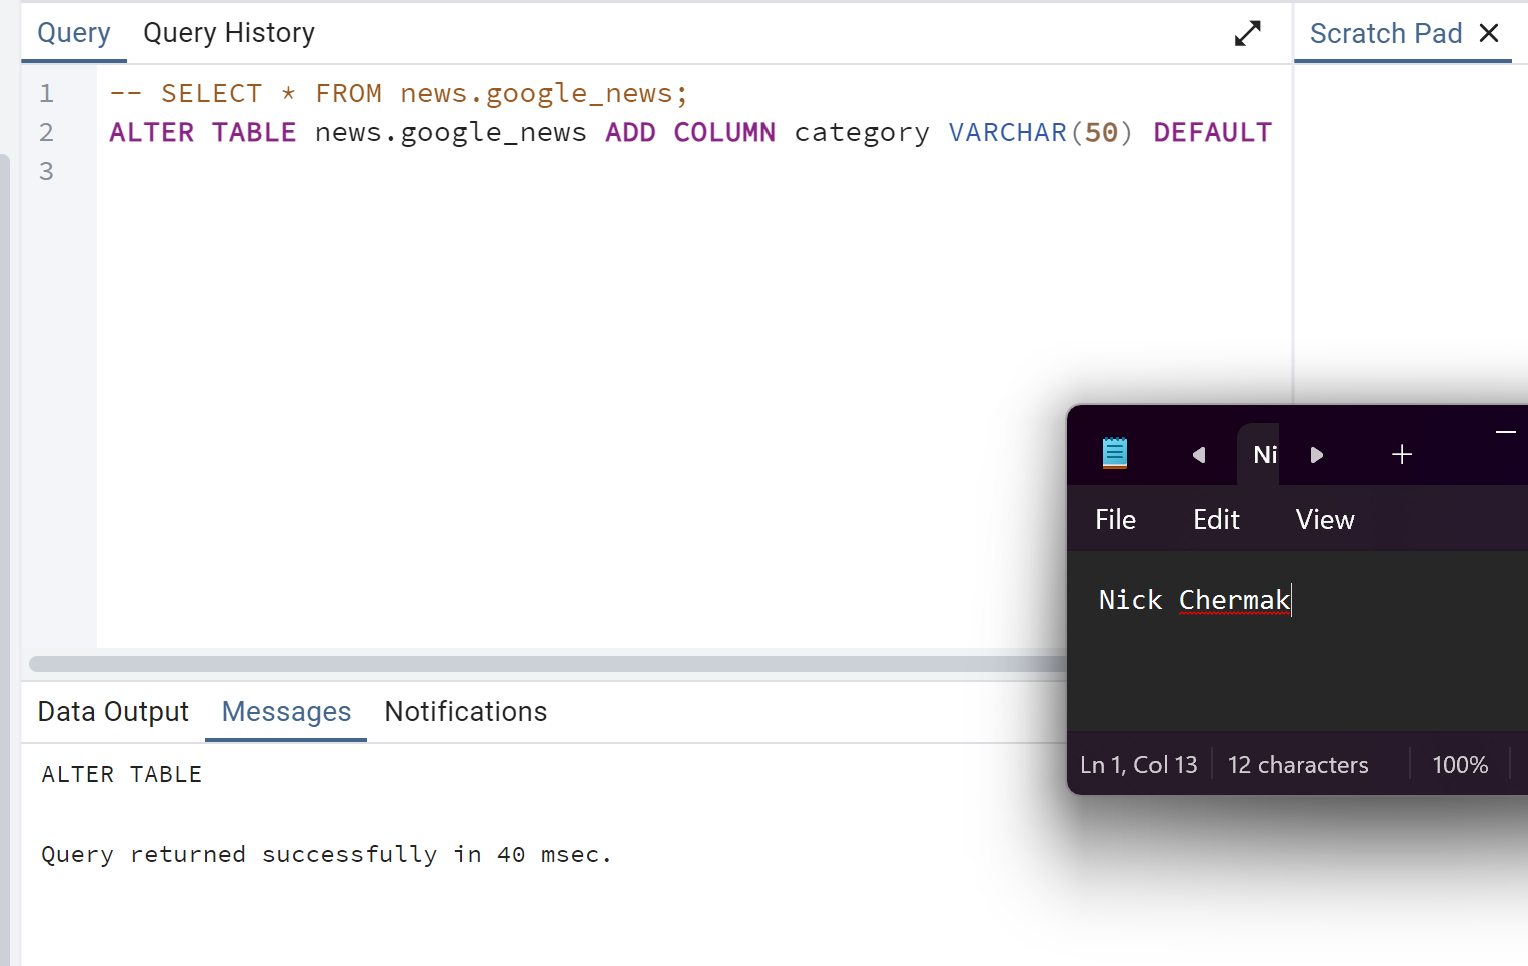

# **Q5**


In [15]:
def remove_records_with(instance, spark, jdbc_url, properties):
    try:
        news_df = spark.read.jdbc(url=jdbc_url, table="news.google_news", properties=properties)
        
        # Step 2: Filter out records containing "NFL" in the title
        nfl_filtered_df = news_df.filter(~news_df.title.contains(instance))
        
        # Step 3: Overwrite the table with the filtered data (deleting NFL records)
        nfl_filtered_df.write.jdbc(url=jdbc_url, table="news.google_news", mode="overwrite", properties=properties)
        print("Successfully deleted records containing 'NFL' in the title")
    except Exception as e:
        print(f"Error deleting records containing 'NFL': {e}")
        import traceback
        traceback.print_exc()

remove_records_with("NFL", spark, jdbc_url, properties)

Successfully deleted records containing 'NFL' in the title


In [ ]:
SELECT * FROM news.google_news WHERE title ILIKE '%NFL%';

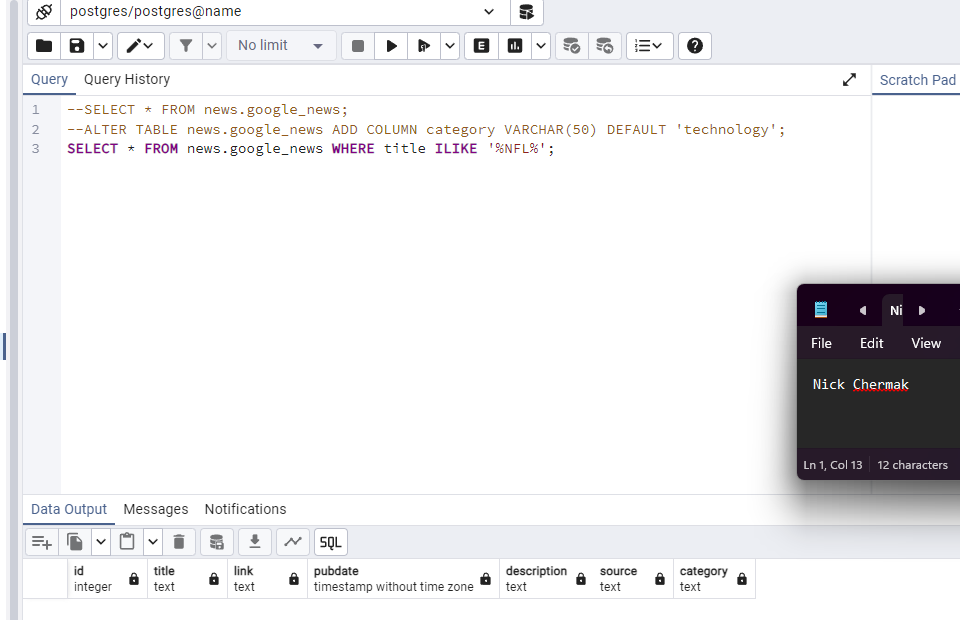

# **Q6**

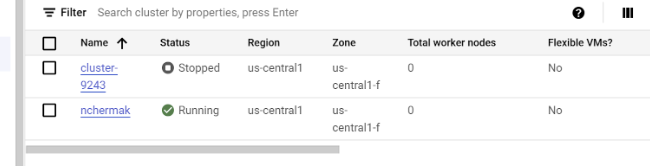

Chat
feedparser
Discussed with Rohan